In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from ncpol2sdpa import *

In [2]:
# read training set

compas=pd.read_csv("cox-parsed.csv",nrows=1000)

compas=compas[['sex','age','race','juv_fel_count','juv_misd_count','priors_count','start','end','event','decile_score']]
# We only choose African-American and Caucasian defendants
compas=compas[(compas["race"]== "African-American")|(compas["race"]== "Caucasian")]
length=compas.shape[0]
compas.index=[*range(length)]

for i in range(length):
# race 1 -> African-American
# race 0 -> Caucasian
    if compas.loc[i,"race"]=="Caucasian":
        compas.loc[i,"race"]=0
    elif compas.loc[i,"race"]=="African-American":
        compas.loc[i,"race"]=1 
# gender 1 -> Female
# gender 0 -> Male
    if compas.loc[i,"sex"]=="Male":
        compas.loc[i,"sex"]=0
    elif compas.loc[i,"sex"]=="Female":
        compas.loc[i,"sex"]=1
# total number of previous convictions
    compas.loc[i,'priors_total_count']=compas.loc[i,'juv_fel_count']+compas.loc[i,'juv_misd_count']+compas.loc[i,'priors_count']
    
# age less than 25
# age greater than 45
    if compas.loc[i,"age"]< 25:
        compas.loc[i,"less25"]=1
        compas.loc[i,"over45"]=0
    elif compas.loc[i,"age"]> 45:
        compas.loc[i,"less25"]=0
        compas.loc[i,"over45"]=1
    else:
        compas.loc[i,"less25"]=0
        compas.loc[i,"over45"]=0
    

In [3]:
compas

,sex,age,race,juv_fel_count,juv_misd_count,priors_count,start,end,event,decile_score,priors_total_count,less25,over45
0,0,34,1,0,0,0,9,159,1,3,0.0,0.0,0.0
1,0,24,1,0,0,4,0,63,0,4,4.0,1.0,0.0
2,0,24,1,0,0,4,63,64,1,4,4.0,1.0,0.0
3,0,23,1,0,1,1,0,1174,0,8,2.0,1.0,0.0
4,0,41,0,0,0,14,5,40,1,6,14.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,0,24,0,0,0,9,0,37,1,10,9.0,1.0,0.0
847,1,26,0,0,0,1,0,519,0,2,1.0,0.0,0.0
848,0,35,1,0,0,6,69,127,0,7,6.0,0.0,0.0
849,0,35,1,0,0,6,208,635,0,7,6.0,0.0,0.0


In [4]:
I = compas.shape[0]
I0=compas[compas['race']==0].index
I1=compas[compas['race']==1].index

I_split = int(I*0.5) 
I0_train=I0[I0<=I_split]
I1_train=I1[I1<=I_split]

# Training

# Model D.No time series; 2 features; age range

In [16]:
# Apply Subgroup-Fair
# Parameters
level = 1

# Decision Variables
a = generate_operators("a", n_vars=1, hermitian=True, commutative=False)[0] # age < 25
b = generate_operators("b", n_vars=1, hermitian=True, commutative=False)[0] # age > 45
c = generate_operators("c", n_vars=1, hermitian=True, commutative=False)[0] # total number of previous convictions
#d = generate_operators("d", n_vars=T, hermitian=True, commutative=False)
e = generate_operators("e", n_vars=1, hermitian=True, commutative=False)[0]
f = generate_operators("f", n_vars=1, hermitian=True, commutative=False)[0]
z = generate_operators("z", n_vars=1, hermitian=True, commutative=True)[0]
#p= generate_operators("p", n_vars=I-int(I*0.5), hermitian=True, commutative=True)

# Constraints
ine1 = [f - a*compas['less25'][i] - b*compas['over45'][i] - c*compas['priors_total_count'][i] - e for i in range(I_split)]
ine2 = [-f + a*compas['less25'][i] + b*compas['over45'][i] + c*compas['priors_total_count'][i] + e for i in range(I_split)]
max1=[z-sum( (f-compas["event"][i])**2 for i in I1_train)]
max0=[z-sum( (f-compas["event"][i])**2 for i in I0_train)]
ine_D=ine1+ine2+max0+max1

# Objective
obj_D = z + 1*e**2

# Solve the fair NCPOP B
sdp_D = SdpRelaxation(variables = flatten([a,b,c,e,f,z]), verbose = 2)
sdp_D.get_relaxation(level, objective=obj_D, inequalities=ine_D)
sdp_D.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
print(sdp_D.primal, sdp_D.dual, sdp_D.status)


The problem has 1 commuting, 5 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 27
Generating moment matrix...
Reduced number of SDP variables: 27 27 (done: 103.70%, ETA 00:00:-0.0)
Processing 852/852 constraints...
52.58963982479783 52.589640316238345 optimal


In [17]:
arr=[]
for i in range(I):
    arr+=[sdp_D[a]*compas['less25'][i] + sdp_D[b]*compas['over45'][i] + sdp_D[c]*compas['priors_total_count'][i]]

#arr = compas['our method_D'].tolist()
arr_nor = [int(10*float(x - np.min(arr))/(np.max(arr) - np.min(arr))) for x in arr]

for i in range(I):
    compas.loc[i,'our score_D']=arr_nor[i]

#compas

# Model C.No time series; 5 features; age range

In [7]:
# Apply Subgroup-Fair
# Parameters
level = 1

# Decision Variables
a = generate_operators("a", n_vars=2, hermitian=True, commutative=False) # age 0: < 25; age 1: > 45  
b = generate_operators("b", n_vars=1, hermitian=True, commutative=False)[0] # sex
c = generate_operators("c", n_vars=1, hermitian=True, commutative=False)[0] # number of juvenile misdemeanors
d = generate_operators("d", n_vars=1, hermitian=True, commutative=False)[0] # number of juvenile felonies
g = generate_operators("g", n_vars=1, hermitian=True, commutative=False)[0] # number of prior

e = generate_operators("e", n_vars=1, hermitian=True, commutative=False)[0]
f = generate_operators("f", n_vars=1, hermitian=True, commutative=False)[0]
z = generate_operators("z", n_vars=1, hermitian=True, commutative=True)[0]

# Constraints
ine1 = [f - a[0]*compas['less25'][i] - a[1]*compas['over45'][i] - b*compas['sex'][i] - c*compas['juv_misd_count'][i]- d*compas['juv_fel_count'][i] - g*compas['priors_count'][i] - e for i in range(I_split)]
ine2 = [-f + a[0]*compas['less25'][i] + a[1]*compas['over45'][i] + b*compas['sex'][i] + c*compas['juv_misd_count'][i]+ d*compas['juv_fel_count'][i] + g*compas['priors_count'][i] + e for i in range(I_split)]
max1=[z-sum( f**2+compas["event"][i]**2-2*compas["event"][i]*f for i in I1_train)]
max0=[z-sum( f**2+compas["event"][i]**2-2*compas["event"][i]*f for i in I0_train)]
#max1=[z-sum((f-compas["event"][i])**2 for i in I1_train)]
#max0=[z-sum((f-compas["event"][i])**2 for i in I0_train)]
ine_C=ine1+ine2+max0+max1

# Objective
obj_C = z + e**2 

# Solve the fair NCPO A
sdp_C = SdpRelaxation(variables = flatten([a,b,c,d,g,e,f,z]), verbose = 2)
sdp_C.get_relaxation(level, objective=obj_C, inequalities=ine_C)
sdp_C.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
print(sdp_C.primal, sdp_C.dual, sdp_C.status)


The problem has 1 commuting, 8 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 54
Generating moment matrix...
Reduced number of SDP variables: 54 54 (done: 101.85%, ETA 00:00:-0.0)
Processing 852/852 constraints...
52.589639826910265 52.58964033441427 optimal


In [14]:
arr=[]
for i in range(I):
    arr+=[sdp_C[a[0]]*compas['less25'][i]+sdp_C[a[1]]*compas['over45'][i]+sdp_C[b]*compas['sex'][i] + sdp_C[c]*compas['juv_misd_count'][i]+ sdp_C[d]*compas['juv_fel_count'][i] + sdp_C[g]*compas['priors_count'][i]]
    
arr_nor = [int(10*float(x - np.min(arr))/(np.max(arr) - np.min(arr))) for x in arr]

for i in range(I):
    compas.loc[i,'our score_C']=arr_nor[i]

#compas

# Testing

# Write down the testing set

In [19]:
compas_test=compas.loc[range(I_split,I),]
compas_test.to_csv('COMPAS_COX.csv')

# 1. compare overall accuracy

In [20]:
def perf_measure(y_actual, y_hat):
#Output: False positive rate; False negative rate; Accuracy
# Positive event is being predicted to re-offend  
# Negative event is being predicted not to re-offend  

    TP = 0
    TN = 0
    FP = 0 # False Positive
    FN = 0 # False Negative
    Acc = 0 # Accuracy
    
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
        if y_actual[i]!=y_hat[i]:
            Acc += 1

    return(FP/(FP+TP),FN/(FN+TN),(len(y_hat)-Acc)/len(y_hat))
    #return(TP, FP, TN, FN)

In [31]:
# We assume high risk score (>= 8) refers to being prediected to re-offend 
th=8 # threshold for positive and negative events

y_C=(compas_test['our score_C']>=th).astype(int).tolist()
y_D=(compas_test['our score_D']>=th).astype(int).tolist()

y_compas=(compas_test['decile_score']>=8).astype(int).tolist()
y_actual=compas_test['event'].tolist()

In [32]:
perf_measure(y_actual,y_compas)

(0.5894736842105263, 0.19939577039274925, 0.7136150234741784)

In [34]:
perf_measure(y_actual,y_D)

(0.4, 0.24228028503562946, 0.755868544600939)

# 2. compare accuracy by race

In [36]:
I_test = compas_test.shape[0]
I0_test=compas_test[compas_test['race']==0].index
I1_test=compas_test[compas_test['race']==1].index

In [39]:
y_C_I0=(compas_test.loc[I0_test,'our score_C']>=th).astype(int).tolist()
y_D_I0=(compas_test.loc[I0_test,'our score_D']>=th).astype(int).tolist()

y_compas_I0=(compas_test.loc[I0_test,'decile_score']>=8).astype(int).tolist()
y_actual_I0=compas_test.loc[I0_test,'event'].tolist()

y_C_I1=(compas_test.loc[I1_test,'our score_C']>=th).astype(int).tolist()
y_D_I1=(compas_test.loc[I1_test,'our score_D']>=th).astype(int).tolist()

y_compas_I1=(compas_test.loc[I1_test,'decile_score']>=8).astype(int).tolist()
y_actual_I1=compas_test.loc[I1_test,'event'].tolist()

In [40]:
perf_measure(y_actual_I0,y_compas_I0)

(0.6190476190476191, 0.17365269461077845, 0.776595744680851)

In [41]:
perf_measure(y_actual_I1,y_compas_I1)

(0.581081081081081, 0.22560975609756098, 0.6638655462184874)

In [42]:
perf_measure(y_actual_I0,y_D_I0)

(0.6666666666666666, 0.1945945945945946, 0.7978723404255319)

In [43]:
perf_measure(y_actual_I1,y_D_I1)

(0.0, 0.2796610169491525, 0.7226890756302521)

# The end
# The rest won't be used

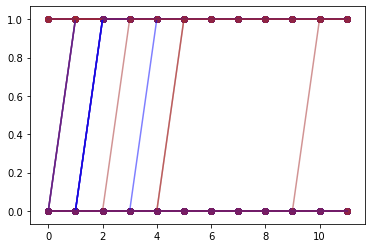

In [3]:
Ind=np.empty([compas.shape[0],12])
for i in range(length):
    start=int(compas.loc[i,"start"]/100)
    end=int(compas.loc[i,"end"]/100)
    list_i=[None]*start+[0]*(end-start)+[compas.loc[i,"event"]]*(12-end)
    Ind[i,]=list_i
    if compas.loc[i,"race"]==0:
        color='blue'
    elif compas.loc[i,"race"]==1:
        color='brown'
    #print(len(list_i))
    plt.scatter([*range(len(list_i))],list_i,color=color,alpha=0.5)
    plt.plot(list_i,color=color,alpha=0.5)

In [375]:
Ind

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  

# A.Time series; 2 features

In [70]:
# Apply Subgroup-Fair
# Parameters
level = 1
T = 12
#group = 2
#trajectory = [compas[compas['race']==0].shape[0],compas[compas['race']==1].shape[0]] # 21 for race 1 & race 0
#sum_traj = sum(trajectory)

# Decision Variables
a = generate_operators("a", n_vars=T, hermitian=True, commutative=False) # age 
b = generate_operators("b", n_vars=T, hermitian=True, commutative=False) # total number of previous convictions
c = generate_operators("c", n_vars=T, hermitian=True, commutative=False)
#d = generate_operators("d", n_vars=T, hermitian=True, commutative=False)
e = generate_operators("e", n_vars=T, hermitian=True, commutative=False)
f = generate_operators("f", n_vars=T, hermitian=True, commutative=True)
z = generate_operators("z", n_vars=1, hermitian=True, commutative=True)[0]
#p= generate_operators("p", n_vars=I-int(I*0.5), hermitian=True, commutative=True)

# Constraints
ine1 = [f[t] - a[t]*compas['age'][i] - b[t]*compas['priors_total_count'][i] - c[t]*compas['age'][i]*compas['priors_total_count'][i] - e[t]  for t in range(T) for i in range(I_split)]
ine2 = [-f[t] + a[t]*compas['age'][i] + b[t]*compas['priors_total_count'][i] + c[t]*compas['age'][i]*compas['priors_total_count'][i] + e[t] for t in range(T) for i in range(I_split)]
#ine1 = [f[t] - a[t]*compas['age'][i] - b[t]*compas['age'][i] - c[t]*compas['age'][i] - d[t]*compas['age'][i] - e[t] for t in range(T) for i in range(I)]
#ine2 = [-f[t] + a[t]*compas['age'][i] + b[t]*compas['age'][i] + c[t]*compas['age'][i] + d[t]*compas['age'][i] + e[t] for t in range(T) for i in range(I)]
max1=[z-sum((f[t]-Ind[i,t])**2 for t in range(T) for i in I1_train if ~np.isnan(Ind[i,t]))/I1_train_count]
max0=[z-sum((f[t]-Ind[i,t])**2 for t in range(T) for i in I0_train if ~np.isnan(Ind[i,t]))/I0_train_count]

#res1=[p[i-I_split] - a[T-1]*compas['age'][i] - b[T-1]*compas['priors_total_count'][i] for i in range(I_split,I)]
#res2=[-p[i-I_split] + a[T-1]*compas['age'][i] + b[T-1]*compas['priors_total_count'][i] for i in range(I_split,I)]

ine_A=ine1+ine2+max0+max1 #+res1+res2

# Objective
obj_A = z + 0.1*sum(e[i]**2 for i in range(T)) 

# Solve the fair NCPO A
sdp_A = SdpRelaxation(variables = flatten([a,b,c,f,e,z]), verbose = 2)
sdp_A.get_relaxation(level, objective=obj_A, inequalities=ine_A)
sdp_A.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
print(sdp_A.primal, sdp_A.dual, sdp_A.status)


The problem has 13 commuting, 48 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952952 (done: 100.05%, ETA 00:00:-0.0)
Processing 986/986 constraints...
0.30012090340783915 0.300120253356822 unknown


In [71]:
for i in range(I):
    compas.loc[i,'our method_A']=sdp_A[a[T-1]*compas['age'][i] + b[T-1]*compas['priors_total_count'][i] + c[T-1]*compas['age'][i]*compas['priors_total_count'][i] ]

arr = compas['our method_A'].tolist()
arr_nor = [10*float(x - np.min(arr))/(np.max(arr) - np.min(arr)) for x in arr]

for i in range(I):
    compas.loc[i,'our score_A']=arr_nor[i]

compas

,sex,age,race,juv_fel_count,juv_misd_count,priors_count,start,end,event,decile_score,priors_total_count,our method_C,our score_C,our method_A,our score_A
0,0,34,1,0,0,0,9,159,1,3,0.0,2.399720e-11,3.048342,5.161200e-11,3.255814
1,0,24,1,0,0,4,0,63,0,4,4.0,1.735760e-11,1.000031,4.534160e-11,2.295186
2,0,23,1,0,1,1,0,1174,0,8,2.0,2.787800e-11,4.245565,3.964060e-11,1.421791
3,0,41,0,0,0,14,5,40,1,6,14.0,3.040220e-11,5.024279,6.107740e-11,4.705917
4,1,39,0,0,0,0,2,747,0,1,0.0,2.944720e-11,4.729662,5.920200e-11,4.418605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,27,1,0,1,6,30,193,1,6,7.0,3.122420e-11,5.277865,5.372390e-11,3.579358
78,1,56,1,0,0,0,3,916,0,1,0.0,4.144580e-11,8.431220,8.500800e-11,8.372093
79,1,31,0,0,0,2,0,510,0,3,2.0,2.401000e-11,3.052291,4.961020e-11,2.949137
80,0,34,1,0,0,0,1178,1179,0,4,0.0,2.399720e-11,3.048342,5.161200e-11,3.255814


# B. No time series; 2 features

In [76]:
# no time series
# Apply Subgroup-Fair
# Parameters
level = 1
#T = 12
#group = 2
#trajectory = [compas[compas['race']==0].shape[0],compas[compas['race']==1].shape[0]] # 21 for race 1 & race 0
#sum_traj = sum(trajectory)

# Decision Variables
a = generate_operators("a", n_vars=1, hermitian=True, commutative=False)[0] # age 
b = generate_operators("b", n_vars=1, hermitian=True, commutative=False)[0] # total number of previous convictions
c = generate_operators("c", n_vars=1, hermitian=True, commutative=False)[0]
#d = generate_operators("d", n_vars=T, hermitian=True, commutative=False)
e = generate_operators("e", n_vars=1, hermitian=True, commutative=False)[0]
f = generate_operators("f", n_vars=1, hermitian=True, commutative=False)[0]
z = generate_operators("z", n_vars=1, hermitian=True, commutative=True)[0]
#p= generate_operators("p", n_vars=I-int(I*0.5), hermitian=True, commutative=True)

# Constraints
ine1 = [f - a*compas['age'][i] - b*compas['priors_total_count'][i] - c*compas['age'][i]*compas['priors_total_count'][i] - e for i in range(I_split)]
ine2 = [-f + a*compas['age'][i] + b*compas['priors_total_count'][i] + c*compas['age'][i]*compas['priors_total_count'][i] + e for i in range(I_split)]
max1=[z-sum( (f-compas["event"][i])**2 for i in I1_train)]
max0=[z-sum( (f-compas["event"][i])**2 for i in I0_train)]
perf_measure(y_actual,y_C)
ine_B=ine1+ine2+max0+max1

# Objective
obj_B = z + 1*sum(e**2 for i in range(T)) 

# Solve the fair NCPOP B
sdp_B = SdpRelaxation(variables = flatten([a,b,c,e,f,z]), verbose = 2)
sdp_B.get_relaxation(level, objective=obj_B, inequalities=ine_B)
sdp_B.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
print(sdp_B.primal, sdp_B.dual, sdp_B.status)


The problem has 1 commuting, 5 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 27
Generating moment matrix...
Reduced number of SDP variables: 27 27 (done: 103.70%, ETA 00:00:-0.0)
Processing 84/84 constraints...
6.685713982328277 6.685713748615642 optimal


In [78]:
for i in range(I):
    compas.loc[i,'our method_B']=sdp_B[a*compas['age'][i] + b*compas['priors_total_count'][i] + c*compas['age'][i]*compas['priors_total_count'][i] ]

arr = compas['our method_B'].tolist()
arr_nor = [10*float(x - np.min(arr))/(np.max(arr) - np.min(arr)) for x in arr]

for i in range(I):
    compas.loc[i,'our score_B']=arr_nor[i]

compas

,sex,age,race,juv_fel_count,juv_misd_count,priors_count,start,end,event,decile_score,priors_total_count,our method_C,our score_C,our method_A,our score_A,our method_B,our score_B
0,0,34,1,0,0,0,9,159,1,3,0.0,2.399720e-11,3.048342,5.161200e-11,3.255814,3.218440e-09,3.255814
1,0,24,1,0,0,4,0,63,0,4,4.0,1.735760e-11,1.000031,4.534160e-11,2.295186,2.827360e-09,2.295019
2,0,23,1,0,1,1,0,1174,0,8,2.0,2.787800e-11,4.245565,3.964060e-11,1.421791,2.471900e-09,1.421735
3,0,41,0,0,0,14,5,40,1,6,14.0,3.040220e-11,5.024279,6.107740e-11,4.705917,3.807140e-09,4.702116
4,1,39,0,0,0,0,2,747,0,1,0.0,2.944720e-11,4.729662,5.920200e-11,4.418605,3.691740e-09,4.418605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0,27,1,0,1,6,30,193,1,6,7.0,3.122420e-11,5.277865,5.372390e-11,3.579358,3.349900e-09,3.578781
78,1,56,1,0,0,0,3,916,0,1,0.0,4.144580e-11,8.431220,8.500800e-11,8.372093,5.300960e-09,8.372093
79,1,31,0,0,0,2,0,510,0,3,2.0,2.401000e-11,3.052291,4.961020e-11,2.949137,3.093500e-09,2.948865
80,0,34,1,0,0,0,1178,1179,0,4,0.0,2.399720e-11,3.048342,5.161200e-11,3.255814,3.218440e-09,3.255814
